<a href="https://colab.research.google.com/github/csabiu/KAML-2025/blob/main/KAML_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
pip install astroquery

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 89.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 999.4/999.4 kB 51.0 MB/s eta 0:00:00


In [5]:
# 1) Install dependencies (in Colab you’d run these once):
# !pip install astroquery pandas pillow

import os
import numpy as np
import pandas as pd
from astroquery.sdss import SDSS
from astropy import coordinates as coords
from astropy import units as u
from PIL import Image
import matplotlib.pyplot as plt


# 2) Download the debiased GZ2 Table 1 (Hart et al. 2016)
#    This CSV has ~240 000 galaxies with ra, dec, dr7objid, and vote fractions.
url = 'https://gz2hart.s3.amazonaws.com/gz2_hart16.csv.gz'
df = pd.read_csv(url, compression='gzip')
# :contentReference[oaicite:0]{index=0}

# 3) Sample a small set for our tutorial (e.g. 20 galaxies)
df_sample = df.sample(n=20, random_state=42)[['dr7objid','ra','dec']]

# 4) Create a directory to save your cutouts
os.makedirs('cutouts', exist_ok=True)




Failed to fetch 587736542021812480: SDSSClass.get_images() got an unexpected keyword argument 'coord'
Failed to fetch 588009370152927360: SDSSClass.get_images() got an unexpected keyword argument 'coord'
Failed to fetch 588017627774713984: SDSSClass.get_images() got an unexpected keyword argument 'coord'
Failed to fetch 588007005259890816: SDSSClass.get_images() got an unexpected keyword argument 'coord'
Failed to fetch 587734893829423232: SDSSClass.get_images() got an unexpected keyword argument 'coord'
Failed to fetch 587741489829314688: SDSSClass.get_images() got an unexpected keyword argument 'coord'
Failed to fetch 587741603109667072: SDSSClass.get_images() got an unexpected keyword argument 'coord'
Failed to fetch 588023722322493696: SDSSClass.get_images() got an unexpected keyword argument 'coord'
Failed to fetch 588023668628586624: SDSSClass.get_images() got an unexpected keyword argument 'coord'
Failed to fetch 587742012763930880: SDSSClass.get_images() got an unexpected keywo

In [8]:
# 5) Fetch and save RGB cutouts from SDSS
for _, row in df_sample.iterrows():
    objid = int(row['dr7objid'])
    ra, dec = row['ra'], row['dec']
    pos = coords.SkyCoord(ra, dec, unit=u.deg)
    try:
        # get_images returns a list of HDULists in the order of the 'band' list
        hdulists = SDSS.get_images(pos, band=['g','r','i'],)
        # assemble an (64×64×3) array
        rgb = np.stack([hdulist[0].data for hdulist in hdulists], axis=-1)
        # normalize to 0–255 for display
        norm = (rgb - np.nanmin(rgb)) / (np.nanmax(rgb) - np.nanmin(rgb))
        img8 = (norm * 255).astype(np.uint8)
        Image.fromarray(img8).save(f'cutouts/{objid}.png')
    except Exception as e:
        print(f"Failed to fetch {objid}: {e}")

Failed to fetch 587736542021812480: SDSSClass.get_images() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
Failed to fetch 588009370152927360: SDSSClass.get_images() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
Failed to fetch 588017627774713984: SDSSClass.get_images() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
Failed to fetch 588007005259890816: SDSSClass.get_images() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
Failed to fetch 587734893829423232: SDSSClass.get_images() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
Failed to fetch 587741489829314688: SDSSClass.get_images() takes 1 positional argument but 2 positional arguments (and 1 keyword-only argument) were given
Failed to fetch 587741603109667072: SDSSClass.get_images() takes 1 pos

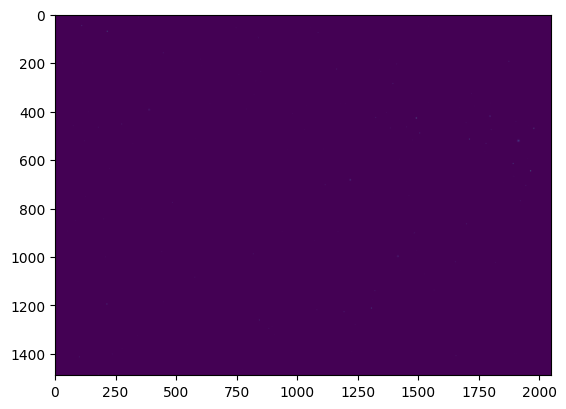

In [46]:
plt.imshow(rgb[:,:,1])


In [75]:
import os
import requests
from PIL import Image
from io import BytesIO

# 1. Helper to fetch an SDSS JPEG cutout
def fetch_sdss_cutout(ra, dec, scale=0.2, width=64, height=64, timeout=60):
    """
    ra, dec     : sky coordinates in degrees
    scale       : arcsec per pixel
    width, height: cutout size in pixels
    timeout     : seconds to wait for server
    """
    url = "https://skyserver.sdss.org/dr16/SkyServerWS/ImgCutout/getjpeg"
    params = {
        'ra': ra,
        'dec': dec,
        'scale': scale,
        'width': width,
        'height': height,
        'opt': 'G'   # produce an RGB image
    }
    r = requests.get(url, params=params, timeout=timeout)
    r.raise_for_status()
    return Image.open(BytesIO(r.content))

# 2. Example: loop over your df_sample and save PNGs
os.makedirs('cutouts_http', exist_ok=True)

for _, row in df_sample.iterrows():
    objid = int(row['dr7objid'])
    ra, dec = row['ra'], row['dec']
    try:
        img = fetch_sdss_cutout(ra, dec,
                                scale=0.2,   # ~0.2″/px
                                width=128,
                                height=128)
        img.save(f'cutouts_http/{objid}.png')
    except Exception as e:
        print(f"Failed {objid}: {e}")


In [82]:
img.

<bound method Image.getdata of <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=128x128 at 0x78475726CA10>>